# Dimensionality Reduction Example

Using the IMDB data, feature matrix and apply dimensionality reduction to this matrix via PCA and SVD.

In [2]:
%matplotlib inline

In [3]:
import json
import random
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from scipy.sparse import lil_matrix

from sklearn.neighbors import DistanceMetric

from sklearn.metrics import jaccard_score
from sklearn.metrics import pairwise_distances

In [4]:
# Let's restrict ourselves just to US titles
relevant_title_df = pd.read_csv("../data/us_relevant_titles.csv")

# And create a set of just these titles, so we can filter them
relevant_title_set = set(relevant_title_df["title"])

In [5]:
actor_id_to_name_map = {}     # Map Actor IDs to actor names
actor_id_to_index_map = {}    # Map actor IDs to a unique index of known actors
index_to_actor_ids = []       # Array mapping unique index back to actor ID (invert of actor_id_to_index_map)

index_counter = 0    # Unique actor index; increment for each new actor
known_actors = set()

movie_actor_list = [] # List of all our movies and their actors

test_count = 0
with open("../data/imdb_recent_movies.json", "r") as in_file:
    for line in in_file:
        
        this_movie = json.loads(line)
        
        # Restrict to American movies
        if this_movie["title_name"] not in relevant_title_set:
            continue
            
        # Keep track of all the actors in this movie
        for actor_id,actor_name in zip(this_movie['actor_ids'],this_movie['actor_names']):
            
            # Keep names and IDs
            actor_id_to_name_map[actor_id] = actor_name
            
            # If we've seen this actor before, skip...
            if actor_id in known_actors:
                continue
                
            # ... Otherwise, add to known actor set and create new index for them
            known_actors.add(actor_id)
            actor_id_to_index_map[actor_id] = index_counter
            index_to_actor_ids.append(actor_id)
            index_counter += 1
            
        # Finished with this film
        movie_actor_list.append({
            "movie": this_movie["title_name"],
            "actors": set(this_movie['actor_ids']),
            "genres": this_movie["title_genre"]
        })

In [6]:
print("Known Actors:", len(known_actors))

Known Actors: 161996


## Generate Same DataFrame using Sparse Matrics

The above will break if you have too much data. We can get around that partially with sparse matrices, where we only store the non-zero elements of the feature matrix and their indices.

In [7]:
# With sparse matrix, initialize to size of Movies x Actors of 0s
matrix_sparse = lil_matrix((len(movie_actor_list), len(known_actors)), dtype=bool)

# Update the matrix, movie by movie, setting non-zero values for the appropriate actors
for row,movie in enumerate(movie_actor_list):   
    for actor_id in movie["actors"]:
        this_index = actor_id_to_index_map[actor_id]
        matrix_sparse[row,this_index] = 1

In [8]:
df = pd.DataFrame.sparse.from_spmatrix(
    matrix_sparse, 
    index=[m["movie"] for m in movie_actor_list],
    columns=[index_to_actor_ids[i] for i in range(len(known_actors))]
)
df

,nm0001379,nm0000953,nm0864851,nm0933983,nm0329491,nm0000123,nm0000221,nm0307255,nm0635649,nm0033458,...,nm10823679,nm1290838,nm5580678,nm8370368,nm0578248,nm2952127,nm3611859,nm9445072,nm8594703,nm8680851
The Other Side of the Wind,1,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
The Naked Monster,0,0,1,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Grizzly II: Revenge,0,0,0,0,0,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Chief Zabu,0,0,0,0,0,0,0,1,1,1,...,0,0,0,0,0,0,0,0,0,0
Crime and Punishment,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Life Without Sara Amat,0,0,0,0,0,0,0,0,0,0,...,1,1,1,0,0,0,0,0,0,0
The Rehearsal,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,1,0,0,0,0,0
Safeguard,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
Coven,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [9]:
top_k_actors = 1000

In [10]:
# Extract the most frequent actors, so we can deal with a reasonable dataset size
actor_df = df.sum(axis=0)
top_actors = set(actor_df.sort_values().tail(top_k_actors).index)

In [11]:
# Restrict the data frame to just the movies containing
#. the top k actors
reduced_df = df[top_actors] # restrict to just these top actors

# throw away movies that don't have any of these actors
reduced_df = reduced_df.loc[reduced_df.sum(axis=1) > 0] 

reduced_df

,nm0504899,nm0001002,nm0000219,nm0005258,nm0275244,nm0664469,nm0000920,nm0091035,nm0001326,nm0000288,...,nm0665114,nm0920460,nm0001698,nm0000438,nm1002207,nm0309575,nm0044762,nm0350453,nm0001803,nm1954434
Grizzly II: Revenge,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Crime and Punishment,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
For the Cause,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Gang,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
In the Mood for Love,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Fox Hunting,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Mountain Quest,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Enemy Lines,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Manoharam,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Apply SVD to Feature Matrix

In [12]:
# https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.TruncatedSVD.html
from sklearn.decomposition import TruncatedSVD 

In [13]:
matrix_dense = reduced_df.to_numpy()
reduced_df

,nm0504899,nm0001002,nm0000219,nm0005258,nm0275244,nm0664469,nm0000920,nm0091035,nm0001326,nm0000288,...,nm0665114,nm0920460,nm0001698,nm0000438,nm1002207,nm0309575,nm0044762,nm0350453,nm0001803,nm1954434
Grizzly II: Revenge,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Crime and Punishment,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
For the Cause,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Gang,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
In the Mood for Love,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Fox Hunting,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Mountain Quest,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Enemy Lines,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Manoharam,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [14]:
svd = TruncatedSVD(n_components=2)

In [15]:
svd.fit(matrix_dense)

TruncatedSVD()

In [17]:
matrix_reduced = svd.transform(matrix_dense)

In [18]:
np.mean(matrix_reduced, axis=0)

array([0.012337 , 0.0081288])

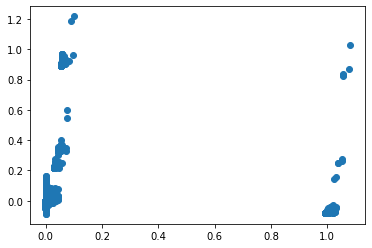

In [19]:
plt.scatter(matrix_reduced[:,0], matrix_reduced[:,1])

In [20]:
counter = 0
for index in np.argwhere((matrix_reduced[:,0] > 1.0) & (matrix_reduced[:,1] > 0.8)):
    movie_title = reduced_df.iloc[index[0]].name
    for this_movie in [m for m in movie_actor_list if m['movie'] == movie_title]:

        print(this_movie["movie"])
        print("\tGenres:", ", ".join(this_movie["genres"]))
        print("\tActors:", ", ".join([actor_id_to_name_map[actor] for actor in this_movie["actors"]]))

    counter += 1
    if counter > 10:
        print("...")
        break    

The Alternate
	Genres: Action, Drama
	Actors: Ice-T, Eric Roberts, Bryan Genesse, Michael Madsen
Luck of the Draw
	Genres: Crime, Drama, Thriller
	Actors: Michael Madsen, Dennis Hopper, Eric Roberts, James Marshall
Skin Traffik
	Genres: Action, Crime
	Actors: Michael Madsen, Eric Roberts, Mickey Rourke
Mission: The Prophet
	Genres: Action, Thriller
	Actors: Aleksey Chadov, Oded Fehr, Alexander Nevsky, Eric Roberts, Stephen Baldwin, Michael Madsen, Casper Van Dien
Beyond the Game
	Genres: Action, Drama
	Actors: Michael Madsen, Eric Roberts, Mark Dacascos, Danny Trejo


In [21]:
counter = 0
for index in np.argwhere((matrix_reduced[:,0] < 0.1) & (matrix_reduced[:,1] < 0.1)):
    movie_title = reduced_df.iloc[index[0]].name
    for this_movie in [m for m in movie_actor_list if m['movie'] == movie_title]:

        print(this_movie["movie"])
        print("\tGenres:", ", ".join(this_movie["genres"]))
        print("\tActors:", ", ".join([actor_id_to_name_map[actor] for actor in this_movie["actors"]]))

    counter += 1
    if counter > 10:
        print("...")
        break    

Grizzly II: Revenge
	Genres: Horror, Music, Thriller
	Actors: George Clooney, Charlie Sheen
Crime and Punishment
	Genres: Drama
	Actors: John Hurt, Crispin Glover
For the Cause
	Genres: Action, Adventure, Drama
	Actors: Dean Cain, Justin Whalin, Thomas Ian Griffith
For the Cause
	Genres: Drama
	Actors: Eugene Parker, Jerod Haynes, Anthony Lemay
For the Cause
	Genres: Comedy
	Actors: Abdelghani Sannak, Ramzi Maqdisi, Jeremy Banster
Gang
	Genres: Action, Crime, Drama
	Actors: Jackie Shroff, Kumar Gaurav, Nana Patekar, Jaaved Jaaferi
Gang
	Genres: Action
	Actors: Ji-Hyuk Cha
In the Mood for Love
	Genres: Drama, Romance
	Actors: Tony Chiu-Wai Leung, Siu Ping-Lam, Tung Cho 'Joe' Cheung
Chinese Coffee
	Genres: Drama
	Actors: Jerry Orbach, Al Pacino
Fandango
	Genres: \N
	Actors: Moritz Bleibtreu, Lars Rudolph, Richy Müller
Fandango
	Genres: Drama
	Actors: Arturo Meseguer, Martín Zapata
The Dancer Upstairs
	Genres: Crime, Drama, Thriller
	Actors: Juan Diego Botto, Javier Bardem
Don's Plum
	Gen

In [22]:
comp1_genre_map = {}
comp1_actor_map = {}

comp1_counter = 0
for index in np.argwhere((matrix_reduced[:,0] > 1.0) & (matrix_reduced[:,1] < 0.2)):
    movie_title = reduced_df.iloc[index[0]].name
    for this_movie in [m for m in movie_actor_list if m['movie'] == movie_title]:
        for g in this_movie["genres"]:
            comp1_genre_map[g] = comp1_genre_map.get(g, 0) + 1
        for a in [actor_id_to_name_map[actor] for actor in this_movie["actors"]]:
            comp1_actor_map[a] = comp1_actor_map.get(a, 0) + 1

    comp1_counter += 1
    
print("Movies in Component 1:", comp1_counter)

print("Genres:")
for g in sorted(comp1_genre_map, key=comp1_genre_map.get, reverse=True)[:10]:
    print("\t", g, comp1_genre_map[g])
print("Actors:")
for a in sorted(comp1_actor_map, key=comp1_actor_map.get, reverse=True)[:10]:
    print("\t", a, comp1_actor_map[a])

Movies in Component 1: 47
Genres:
	 Drama 29
	 Action 23
	 Thriller 22
	 Horror 17
	 Crime 10
	 Mystery 9
	 Fantasy 5
	 Adventure 4
	 Comedy 4
	 Sci-Fi 3
Actors:
	 Eric Roberts 47
	 Vernon Wells 4
	 Armand Assante 4
	 Martin Kove 4
	 Gary Daniels 3
	 Dean Cain 2
	 David A.R. White 2
	 John Savage 2
	 Aaron Groben 2
	 Noel Gugliemi 2


In [26]:
comp2_genre_map = {}
comp2_actor_map = {}

comp2_counter = 0
for index in np.argwhere((matrix_reduced[:,0] < 0.1) & (matrix_reduced[:,1] < 0.1)):
    movie_title = reduced_df.iloc[index[0]].name

    for this_movie in [m for m in movie_actor_list if m['movie'] == movie_title]:
        for g in this_movie["genres"]:
            comp2_genre_map[g] = comp2_genre_map.get(g, 0) + 1
        for a in [actor_id_to_name_map[actor] for actor in this_movie["actors"]]:
            comp2_actor_map[a] = comp2_actor_map.get(a, 0) + 1

    comp2_counter += 1
    
print("Movies in Component 2:", comp2_counter)

print("Genres:")
for g in sorted(comp2_genre_map, key=comp2_genre_map.get, reverse=True)[:10]:
    print("\t", g, comp2_genre_map[g])
print("Actors:")
for a in sorted(comp2_actor_map, key=comp2_actor_map.get, reverse=True)[:10]:
    print("\t", a, comp2_actor_map[a])

Movies in Component 2: 18069
Genres:
	 Drama 17274
	 Comedy 7327
	 Thriller 5586
	 Action 5152
	 Crime 3959
	 Romance 3727
	 Horror 3165
	 Mystery 2093
	 Adventure 2032
	 Sci-Fi 1190
Actors:
	 Joe Hammerstone 91
	 Tony Devon 85
	 Louis Koo 85
	 Brahmanandam 79
	 Nicolas Cage 69
	 James Franco 68
	 Prakash Raj 65
	 Samuel L. Jackson 63
	 Willem Dafoe 63
	 Simon Yam 62


## Find Similar Movies in Reduced Dimensional Space

In [23]:
query_idx = [idx for idx,m in enumerate(reduced_df.index) if m == "The Lord of the Rings: The Fellowship of the Ring"][0]
# query_idx = [idx for idx,m in enumerate(reduced_df.index) if m == "Heavy Metal 2000"][0]
# query_idx = [idx for idx,m in enumerate(reduced_df.index) if m == "Casino Royale"][0]
# query_idx = [idx for idx,m in enumerate(reduced_df.index) if m == "Star Wars: Episode II - Attack of the Clones"][0]
query_idx

18

In [24]:
query_v = matrix_reduced[query_idx,:]

In [25]:
query_v

array([ 6.92969425e-05, -1.05424471e-03])

In [26]:
# get distances between all films and query film
distances = pairwise_distances(matrix_reduced, [query_v], metric='euclidean')


In [27]:
distances_df = pd.DataFrame(distances, columns=["distance"])
for idx,row in distances_df.sort_values(by="distance", ascending=True).head(20).iterrows():
    print(idx, reduced_df.iloc[idx].name, row["distance"])

18 The Lord of the Rings: The Fellowship of the Ring 0.0
11487 Days and Nights 1.2209541406754873e-05
18457 The Tomorrow War 1.2776674116332596e-05
6383 My Own Love Song 1.3171993015743094e-05
10102 Best Man Down 1.639756956937894e-05
15541 Kingsglaive: Final Fantasy XV 1.8152531475848637e-05
11126 Mystery Road 2.189655804804624e-05
16715 The Professor 2.5540080923330028e-05
1529 Daddy Day Care 2.589325207709699e-05
8976 Jupiter Ascending 3.269693367234955e-05
5179 Gulabo Sitabo 3.298438040957619e-05
245 Chain of Fools 3.3382949677633855e-05
11309 Guys and a Cop 4.018040821326311e-05
13328 Raped by an Angel 5 4.018040821326311e-05
17381 Film Fanatic 4.018040821326311e-05
5881 Sheep Without a Shepherd 4.018040821326311e-05
7919 Shadows 4.018040821326311e-05
8868 Fox Ghost 4.018040821326311e-05
10860 Tortured Sex Goddess of Ming Dynasty 4.018040821326311e-05
18485 Girl Dorm 4.018040821326311e-05


## SVD and Column Feature Space

Above, we focused on the *movies* in the reduced feature/"concept" space. Here, we will use SVD to map the *actors* into the reduced "concept" space.

In [29]:
# See that the shape of this matrix is *reduced space* X original features
svd.components_.shape

(2, 1000)

We will use this reduced space to inspect the associations with a given actor and the concept set of concepts (i.e., the reduced space)

In [64]:
# query_actor = [idx for idx,name in actor_id_to_name_map.items() if name == "Ewan McGregor"][0]
# query_actor = [idx for idx,name in actor_id_to_name_map.items() if name == "Eric Roberts"][0]
# query_actor = [idx for idx,name in actor_id_to_name_map.items() if name == "Jason Statham"][0]
# query_actor = [idx for idx,name in actor_id_to_name_map.items() if name == "Leonardo DiCaprio"][0]
query_actor = [idx for idx,name in actor_id_to_name_map.items() if name == "George Clooney"][0]
query_actor

'nm0000123'

In [65]:
query_actor_index = np.argwhere(reduced_df.columns == query_actor)[0,0]
query_actor_index

397

In [66]:
# Show the actor strengths across these concepts
svd.components_.T[query_actor_index,:] 

array([ 6.93507789e-06, -3.35155783e-03])

In [67]:
# And you can use this method to evaluate distances between actors in the concept space
distances = pairwise_distances(svd.components_.T, [svd.components_.T[query_actor_index,:]], metric='euclidean')

distances_df = pd.DataFrame(distances, columns=["distance"])
for idx,row in distances_df.sort_values(by="distance", ascending=True).head(20).iterrows():
    print(idx, actor_id_to_name_map[reduced_df.columns[idx]], row["distance"])

397 George Clooney 0.0
854 Lalu Alex 2.1684959239110375e-05
552 Steve Carell 5.765535961270728e-05
950 Liam Neeson 8.58474608863118e-05
494 Tanikella Bharani 0.00011361512397967896
522 Gérard Depardieu 0.00014417276880813264
926 Siddique 0.0001534176616126892
888 Shawn Yue 0.00015625326486224262
584 Kunchacko Boban 0.00022063353354574957
22 Guy Pearce 0.00024232499554002016
794 Robert Downey Jr. 0.0002447877571351057
12 Paul Giamatti 0.00028857145979086976
0 Tony Ka Fai Leung 0.00029564349774853754
900 Mark Wahlberg 0.00029966525624988997
521 Nassar 0.0003054147725516829
9 Christian Bale 0.00030644785930321463
234 Danny Glover 0.000533473514063691
737 Morgan Freeman 0.0005355495134715015
209 Luke Wilson 0.0005536288382481004
236 Jagapathi Babu 0.000554439235632182


## SVD is more scalable than PCA

In [68]:
from sklearn.decomposition import PCA

In [71]:
matrix_sparse.shape

(102445, 161996)

In [70]:
# This will fail
pca = PCA(n_components=2)
pca.fit(matrix_sparse)

TypeError: PCA does not support sparse input. See TruncatedSVD for a possible alternative.

In [72]:
svd = TruncatedSVD(n_components=2)
svd.fit(matrix_sparse)

TruncatedSVD()

In [74]:
matrix_reduced = svd.transform(matrix_sparse)

[0.00230072 0.00068161]


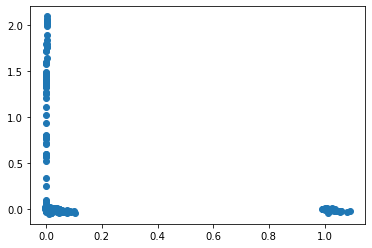

In [75]:
print(np.mean(matrix_reduced, axis=0))
plt.scatter(matrix_reduced[:,0], matrix_reduced[:,1])

In [79]:
comp1_genre_map = {}
comp1_actor_map = {}

comp1_counter = 0
for index in np.argwhere((matrix_reduced[:,0] > 1.0) & (matrix_reduced[:,1] < 0.2)):
    movie_title = df.iloc[index[0]].name
    for this_movie in [m for m in movie_actor_list if m['movie'] == movie_title]:
        for g in this_movie["genres"]:
            comp1_genre_map[g] = comp1_genre_map.get(g, 0) + 1
        for a in [actor_id_to_name_map[actor] for actor in this_movie["actors"]]:
            comp1_actor_map[a] = comp1_actor_map.get(a, 0) + 1

    comp1_counter += 1
    
print("Movies in Component 1:", comp1_counter)

print("Genres:")
for g in sorted(comp1_genre_map, key=comp1_genre_map.get, reverse=True)[:10]:
    print("\t", g, comp1_genre_map[g])
print("Actors:")
for a in sorted(comp1_actor_map, key=comp1_actor_map.get, reverse=True)[:10]:
    print("\t", a, comp1_actor_map[a])

Movies in Component 1: 100
Genres:
	 Drama 72
	 Thriller 49
	 Action 39
	 Horror 31
	 Crime 27
	 Mystery 17
	 Comedy 13
	 Sci-Fi 8
	 Romance 8
	 Adventure 7
Actors:
	 Eric Roberts 100
	 Michael Madsen 5
	 Tom Sizemore 5
	 Vernon Wells 4
	 Armand Assante 4
	 Martin Kove 4
	 Danny Trejo 3
	 Gary Daniels 3
	 Dean Cain 2
	 Casper Van Dien 2


In [80]:
comp2_genre_map = {}
comp2_actor_map = {}

comp2_counter = 0
for index in np.argwhere((matrix_reduced[:,0] < 0.1) & (matrix_reduced[:,1] < 0.1)):
    movie_title = df.iloc[index[0]].name

    for this_movie in [m for m in movie_actor_list if m['movie'] == movie_title]:
        for g in this_movie["genres"]:
            comp2_genre_map[g] = comp2_genre_map.get(g, 0) + 1
        for a in [actor_id_to_name_map[actor] for actor in this_movie["actors"]]:
            comp2_actor_map[a] = comp2_actor_map.get(a, 0) + 1

    comp2_counter += 1
    
print("Movies in Component 2:", comp2_counter)

print("Genres:")
for g in sorted(comp2_genre_map, key=comp2_genre_map.get, reverse=True)[:10]:
    print("\t", g, comp2_genre_map[g])
print("Actors:")
for a in sorted(comp2_actor_map, key=comp2_actor_map.get, reverse=True)[:10]:
    print("\t", a, comp2_actor_map[a])

KeyboardInterrupt: 